In [60]:
#https://raw.githubusercontent.com/fivethirtyeight/data/master/bechdel/
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import process

pd.options.mode.chained_assignment = None

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')


C:\Users\dnishimoto.BOISE\AppData\Roaming\Python\Python37\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Drama        44789
Comedy       38034
Action       27058
Thriller     25252
Adventure    22018
Romance      19340
Crime        16274
Sci-Fi       15366
Fantasy      10658
Children      8681
Name: count, dtype: int64
missing genres 0


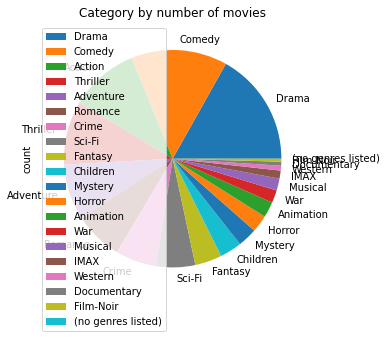

In [113]:
df_movie=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movies.csv", encoding = "ISO-8859-1")
df_ratings=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movie_ratings.csv",encoding = "ISO-8859-1")
df_earnings=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movies_gross_earnings_2013.csv",encoding = "ISO-8859-1",usecols=['imdb','title','domgross_2013$','intgross_2013$'])

df_earnings=df_earnings.rename(columns={'domgross_2013$':'us_gross','intgross_2013$':'international_gross'})
df_earnings['title']=df_earnings['title'].str.replace("&amp;","&")
df_earnings['title']=df_earnings['title'].str.replace("&#39;",",")
df_earnings.set_index('imdb')

#print(df_earnings.head())
#print(df_movie.shape)
#print(df_movie.columns)
#print(df_movie.head())
#print(df_ratings.head())

df=df_movie.merge(df_ratings,on="movieId", how="left") 
df.set_index("movieId")

print(df.columns)

listCategories=[]
for row in df['genres']:
    categories=row.split('|')
    for category in categories:
        if (category in listCategories)==False:
            listCategories.append(category) 
 
for category in listCategories:
        mask=df["genres"].str.contains(category)
        df[category]=0
        df[category][mask]=1
        #print(mask)

    
listCategoryCount=[]

for category in listCategories:
    listCategoryCount.append({'category':category, 'count':df[category].sum()
                             })
rating_threshold=4.5
mask=df['rating']>=rating_threshold
df['liked']=0
df.loc[mask,'liked']=1
    
#add rating and liked count
index=0
for tuple in listCategoryCount:
    category=tuple['category']
    count=tuple['count']
    filter=df[category]==1
    avg_rating=df[filter]['rating'].mean()
    liked_count=df[filter]['liked'].sum()
    update_tuple={'category':category, 'count':count,'avg_rating':avg_rating,'liked_count':liked_count}
    listCategoryCount[index]=update_tuple
    index+=1
    
dfCategory=pd.DataFrame(listCategoryCount,index=listCategories)

dfCategory=dfCategory.sort_values(by="count",ascending=False)
dfCategory.plot.pie(y='count', figsize=(5, 5))
plt.title('Category by number of movies')

print(dfCategory['count'].head(10))
print("missing genres",df['genres'].isnull().sum())





Text(0.5, 1.0, 'Category by avg rating')

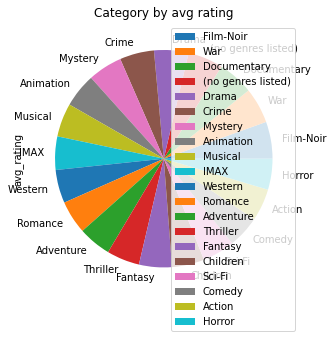

In [114]:
dfCategory=dfCategory.sort_values(by="avg_rating",ascending=False)
dfCategory.plot.pie(y='avg_rating', figsize=(5, 5))
plt.title('Category by avg rating')


Text(0.5, 1.0, 'Category by liked count')

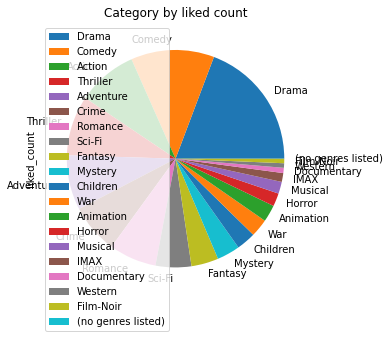

In [115]:
dfCategory=dfCategory.sort_values(by="liked_count",ascending=False)
listLikedFilms=[]
grouped=df.groupby('title')['liked'].sum()
#print(grouped)
listTitles=[]
for key,item in dfCategory.iterrows():
    category=item['category']
    filterCategory=df[category]==1
    titles=df[filterCategory]['title'].unique()
    
    for title in titles:
        if title not in listTitles:
            listTitles.append(title)
            filter=grouped.index==title
            liked_count=grouped[filter].values
            if liked_count>50:
                #print(category,title,liked_count)
                listLikedFilms.append({'category':category, 'title':title,'liked_count':liked_count})

dfFilmsLiked=pd.DataFrame(listLikedFilms)


#filter=df[column]==1
dfCategory.plot.pie(y='liked_count', figsize=(5, 5))
plt.title('Category by liked count')


In [116]:
print('Files with Ratings Greater than {}\n'.format(rating_threshold))
dfFilmsLiked=dfFilmsLiked.sort_values(by=["liked_count"],ascending=False)
for key,item in dfFilmsLiked.iterrows():
    print("{} - {} {}".format(item['category'],item['title'],item['liked_count']))

Files with Ratings Greater than 4.5

Drama - Shawshank Redemption, The (1994) [207]
Drama - Pulp Fiction (1994) [184]
Action - Star Wars: Episode IV - A New Hope (1977) [154]
Action - Matrix, The (1999) [142]
Drama - Schindler's List (1993) [140]
Drama - Forrest Gump (1994) [138]
Thriller - Silence of the Lambs, The (1991) [137]
Drama - Godfather, The (1972) [134]
Action - Star Wars: Episode V - The Empire Strikes Back (1980) [123]
Adventure - Lord of the Rings: The Fellowship of the Ring, The (2001) [117]
Drama - Fargo (1996) [116]
Thriller - Usual Suspects, The (1995) [113]
Drama - American Beauty (1999) [110]
Drama - Fight Club (1999) [103]
Action - Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) [100]
Drama - Lord of the Rings: The Return of the King, The (2003) [99]
Adventure - Lord of the Rings: The Two Towers, The (2002) [98]
Action - Star Wars: Episode VI - Return of the Jedi (1983) [91]
Drama - Braveheart (1995) [89]
Action - Terminator 2: Judgme

In [117]:
listRating=df.groupby(['movieId'])['rating'].mean()
listUserCount=df.groupby(['movieId'])['userId'].count()
listMovieId=df.groupby(['movieId'])['movieId'].unique()
listMovieTitle=df.groupby(['movieId'])['title'].unique()
listLiked =df.groupby(['movieId'])['liked'].sum()

dfPopularity=pd.DataFrame(columns=['movieId'])
dfPopularity.set_index('movieId')

for item in listMovieId:
    movieId=item[0]
    item_to_append=[movieId]
    #item_to_append=pd.Series([movieId,0,0], index = dfPopularity.columns)
    #print(item_to_append)
    #dfPopularity.append(item_to_append,ignore_index=True)
    dfPopularity.loc[len(dfPopularity)]=item_to_append


dfRating=pd.DataFrame(listRating)
dfPopularity=dfPopularity.merge(dfRating, on='movieId',how="left", left_index=True,right_index=True)

dfTitle=pd.DataFrame(listMovieTitle)
dfPopularity=dfPopularity.merge(dfTitle, on='movieId',how="left", left_index=True,right_index=True)

dfUserCount=pd.DataFrame(listUserCount)
dfPopularity=dfPopularity.merge(dfUserCount, on='movieId',how="left", left_index=True,right_index=True)

dfPopularity=dfPopularity.rename(columns={'userId':'user_count'})

dfLiked=pd.DataFrame(listLiked)
dfPopularity=dfPopularity.merge(dfLiked, on='movieId',how="left", left_index=True,right_index=True)

print(dfPopularity.head())

#dfPopularity=pd.DataFrame({'rating':listRating,'count':listUserCount},index=listMovieId)

  movieId    rating                                 title  user_count  liked
0       1  3.872470                    [Toy Story (1995)]         247     82
1       2  3.401869                      [Jumanji (1995)]         107     14
2       3  3.161017             [Grumpier Old Men (1995)]          59      9
3       4  2.384615            [Waiting to Exhale (1995)]          13      0
4       5  3.267857  [Father of the Bride Part II (1995)]          56      8


     movieId    rating                                              title  \
284      318  4.487138                 [Shawshank Redemption, The (1994)]   
48        50  4.370647                       [Usual Suspects, The (1995)]   
472      527  4.303279                          [Schindler's List (1993)]   
535      608  4.256696                                     [Fargo (1996)]   
266      296  4.256173                              [Pulp Fiction (1994)]   
2288    2858  4.236364                           [American Beauty (1999)]   
953     1196  4.232906  [Star Wars: Episode V - The Empire Strikes Bac...   
232      260  4.221649        [Star Wars: Episode IV - A New Hope (1977)]   
955     1198  4.193182  [Raiders of the Lost Ark (Indiana Jones and th...   
2062    2571  4.183398                               [Matrix, The (1999)]   

      user_count  liked  
284          311    207  
48           201    113  
472          244    140  
535          224    116  
266          324    18

<AxesSubplot:xlabel='title'>

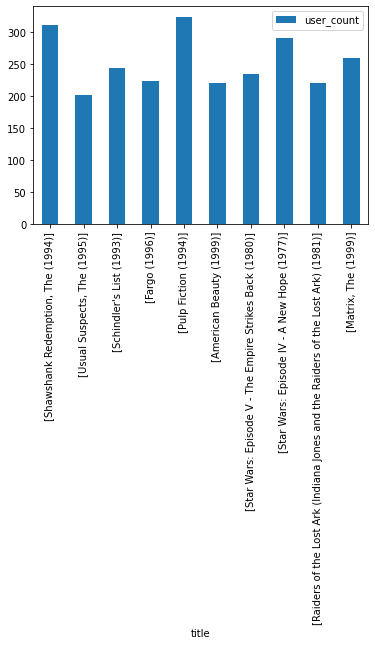

In [118]:
top10=dfPopularity[dfPopularity['user_count']>200].sort_values('rating',ascending=False).head(10)
print(top10)
top10.plot.bar(x="title",y='user_count')

     movieId    rating                                              title  \
284      318  4.487138                 [Shawshank Redemption, The (1994)]   
48        50  4.370647                       [Usual Suspects, The (1995)]   
472      527  4.303279                          [Schindler's List (1993)]   
535      608  4.256696                                     [Fargo (1996)]   
266      296  4.256173                              [Pulp Fiction (1994)]   
953     1196  4.232906  [Star Wars: Episode V - The Empire Strikes Bac...   
232      260  4.221649        [Star Wars: Episode IV - A New Hope (1977)]   
2062    2571  4.183398                               [Matrix, The (1999)]   
2374    2959  4.178218                                [Fight Club (1999)]   

      user_count  liked  popularity  
284          311    207   66.559486  
48           201    113   56.218905  
472          244    140   57.377049  
535          224    116   51.785714  
266          324    184   56.790123  
9

<AxesSubplot:xlabel='title'>

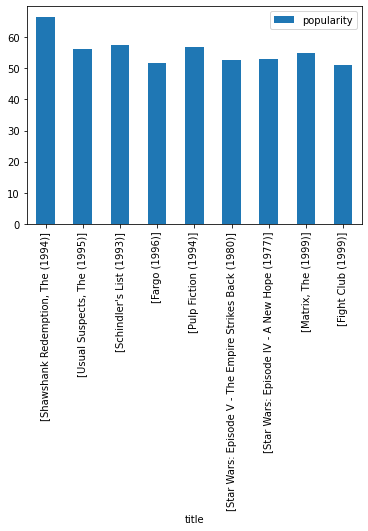

In [119]:
dfPopularity['popularity']= dfPopularity['liked']/dfPopularity['user_count']*100

#print(dfPopularity[['movieId','title','liked','user_count','popularity']])

top10=dfPopularity[(dfPopularity['popularity']>50) & (dfPopularity['user_count']>200) ].sort_values('rating',ascending=False).head(10)
print(top10)
top10.plot.bar(x="title",y='popularity')

In [120]:
def strMerge (df_search,common_column,searchFor):
        result=df_search[df_search[common_column].str.contains(searchFor)==True]
        return result

def is_empty(any_structure):
    if any_structure:
        return False
    else:
        return True
    
def Sort_Tuple(tup):  
    # getting length of list of tuples 
    lst = len(tup)  
    for i in range(0, lst):  
          
        for j in range(0, lst-i-1):  
            if (tup[j][1] > tup[j + 1][1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup      
    
#print(strMerge(df_earnings,'title',"Toy Story",'imdb'))    
    
#dfPopularity.apply(lambda x: result=strMerge(df_earnings,'title',x['title'],axis=1)

#print(df_earnings.head())

createPopularity=False

if createPopularity==True:
    dfPopularity['us_gross']=0.0
    dfPopularity['international_gross']=0.0
    dfPopularity['imdb']=''


    for i in dfPopularity.index: 
        title=dfPopularity['title'][i][0]
        #print("title:",title)
        matches=process.extract(title,df_earnings['title'],limit=df_earnings.shape[0])
        highest_tuple=tuple()
        for potential_match in matches:
            if potential_match[1]>=92:
                print("matches:", potential_match)
                if is_empty(highest_tuple):
                    highest_tuple=potential_match
                if potential_match[1]>= highest_tuple[1]:
                    highest_tuple=potential_match
            #print(type(potential_match))
            #print(row)
            #print(dfPopularity.loc[dfPopularity['title']==potential_match[0],'found'])
        if is_empty(highest_tuple)==False:
            row=df_earnings.loc[df_earnings['title']==highest_tuple[0]].iloc[0]
            #print(row)
            us_gross=row['us_gross'].astype(float)
            international_gross=row['international_gross'].astype(float)
            imdb=row['imdb']
            dfPopularity['us_gross'][i]=us_gross
            dfPopularity['international_gross'][i]=international_gross
            dfPopularity['imdb'][i]=imdb

    print(dfPopularity.head())
    dfPopularity.to_csv('movie_popularity.csv',index=True,index_label="movieId")



In [121]:
if createPopularity==True:
    dfPopularity=pd.read_csv("movie_popularity.csv",encoding = "ISO-8859-1")
else:
    dfPopularity=pd.read_csv("https://raw.githubusercontent.com/dnishimoto/python-deep-learning/master/movie_popularity.csv",encoding = "ISO-8859-1")

<AxesSubplot:xlabel='rating', ylabel='us_gross'>

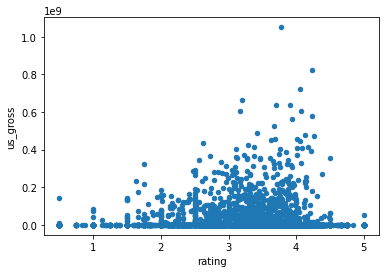

In [122]:
dfPopularity.plot(kind="scatter", x="rating", y="us_gross")

In [123]:
filter=(dfPopularity['popularity']>50) & (dfPopularity['user_count']>10) & (dfPopularity['us_gross']>200000000)
dfPopularity=dfPopularity.sort_values(by=['us_gross'],ascending=[False])
for index, row in dfPopularity[filter].iterrows(): print(row['title'],"${:,.0f}".format(row['us_gross']))



['E.T. the Extra-Terrestrial (1982)'] $1,050,038,377
['Star Wars: Episode V - The Empire Strikes Back (1980)'] $820,821,721
['Star Wars: Episode VI - Return of the Jedi (1983)'] $723,340,482
['Star Wars: Episode I - The Phantom Menace (1999)'] $663,632,711
['Jurassic Park (1993)'] $638,063,379
['Close Encounters of the Third Kind (1977)'] $637,962,288
['Rocky Horror Picture Show, The (1975)'] $605,399,166
['American Graffiti (1973)'] $603,047,833
['Dark Knight, The (2008)'] $577,216,380
['Blazing Saddles (1974)'] $564,485,269
['Beverly Hills Cop (1984)'] $526,202,467
["Pirates of the Caribbean: Dead Man's Chest (2006)"] $489,266,869
['Lord of the Rings: The Return of the King, The (2003)'] $478,385,772
["One Flew Over the Cuckoo's Nest (1975)"] $471,681,892
['Back to the Future (1985)'] $455,981,879
['Dark Knight Rises, The (2012)'] $454,699,213
['Star Wars: Episode III - Revenge of the Sith (2005)'] $453,675,396
['Lord of the Rings: The Two Towers, The (2002)'] $443,662,324
['Transfor

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
